## CAPM Simulation_Jegadeesh et al. (2018) 

In [1]:
## To evaluate the samll sample properties of the IV method, a battery of simulations are conducted using the parameters
## matched to real data.

In [2]:
import pandas as pd
import json
from sklearn.linear_model import LinearRegression
import numpy as np
from scipy import stats
from tqdm import tqdm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.sandbox.regression.gmm import IV2SLS
from datetime import datetime
import linearmodels

In [3]:
def flatten(t):
    return [item for sublist in t for item in sublist]

In [4]:
ols_model = LinearRegression()

In [5]:
## Newey-West Adjustment 
def NW_ttest(ret,h0):
  T = len(ret)
  lag = int(4*(T/100)**(2/9))
  vv = np.var(ret)

  for l in range(0,lag):
      cc=np.cov(ret[0:(len(ret)-l)].T,ret[l:len(ret)].T)[0,1]
      vv=vv+2*(1-(l+1)/lag)*cc
      t=(np.mean(ret)-h0)/np.sqrt(vv)*np.sqrt(T)
  
  return t

In [6]:
df_MR = pd.read_csv('df_MR.csv')
df_MR.Dates = df_MR.Dates.apply(lambda x:x[:10])
df_MR.set_index('Dates',inplace=True)

## Import the simulation parameters from Jegadeesh et al. (2018)

In [7]:
# Import MKT  
mean_MKT = 5.80/100/252
sd_MKT = 15.33/100/np.sqrt(252)
print(mean_MKT, sd_MKT)

0.00023015873015873014 0.009656992285385755


In [8]:
# Import betas
m_all_betas = 0.95
sd_all_betas = 0.42
print(m_all_betas, sd_all_betas)

0.95 0.42


In [9]:
# Import residual sigmas
m_all_sigmas = 58.73/100/252
sd_all_sigmas = 23.81/100/np.sqrt(252)
print(m_all_sigmas, sd_all_sigmas)

0.0023305555555555553 0.014998890170582832


## beta,i and res_sigma,i are fixed through 100 repetitions

In [10]:
# How many stocks in the simulation sample on cross-section
N = 2000

In [11]:
# How many days in the simulation sample on time-series
T = 684*21

In [12]:
sim_betas_tmp = []
sim_betas_tmp.append(np.random.normal(loc = m_all_betas,scale = sd_all_betas, size= N ))
print(np.mean(sim_betas_tmp), np.std(sim_betas_tmp))

0.946984022347864 0.4226233715515209


In [13]:
## ** the betas and sigma(i,resids) are generated at the begining of each simulation and keep them constant
## across 1000 repetitions 
sim_betas = pd.DataFrame(sim_betas_tmp)
# sim_betas = sim_betas.iloc[sim_betas.index.repeat(len(df_Ex_SR)),:]
# sim_betas = sim_betas.reset_index(drop = True)
sim_betas

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,1.380127,0.665771,0.621113,1.418055,1.408961,0.585207,1.08489,1.191176,0.773823,1.866606,...,0.791668,1.121683,1.325342,1.032706,1.118206,0.905882,1.556725,0.877197,1.667773,0.631223


In [14]:
sim_sigmas_tmp = []
sim_sigmas_tmp.append(np.random.normal(loc = m_all_sigmas,scale = sd_all_sigmas, size= N ))
np.mean(sim_sigmas_tmp), np.std(sim_sigmas_tmp)

(0.0023597908272050445, 0.01493202651851501)

In [15]:
sim_sig_res = pd.DataFrame(sim_sigmas_tmp).abs()
sim_sig_res

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,0.003916,0.020253,0.021203,0.010546,0.006286,0.006159,0.01847,0.015498,0.010019,0.023766,...,0.016578,0.002274,0.002871,0.017439,0.010711,0.019696,0.018869,0.008993,0.010628,0.000413


In [16]:
## sum negative values in sim_sig_res
sim_sig_res.values.flatten()
sum(n < 0 for n in sim_sig_res.values.flatten())

0

In [17]:
## Step-2: For each day, we randomly draw market excess return from a normal distribution with mean and standard deviation
## equal to the sample mean and standard deviation from the data

## sim_MKT, sim_SR and res_return are changable through 100 repetitions

In [18]:
sim_MKT_tmp = []
sim_MKT_tmp.append(np.random.normal(loc = mean_MKT,scale = sd_MKT, size= T))
print(mean_MKT, sd_MKT)
print(np.mean(sim_MKT_tmp), np.std(sim_MKT_tmp))

0.00023015873015873014 0.009656992285385755
0.00019396222851541942 0.009800359316564719


In [19]:
sim_MKT = pd.DataFrame(sim_MKT_tmp).T
sim_MKT.index = pd.date_range(start=df_MR.index[0], periods = T, freq='D').astype(str)
sim_MKT.columns = ['RM-RF']
sim_MKT

,RM-RF
2000-01-05,-0.001129
2000-01-06,0.015265
2000-01-07,0.007734
2000-01-08,0.004352
2000-01-09,-0.015813
...,...
2039-04-29,0.008462
2039-04-30,0.003488
2039-05-01,-0.004592
2039-05-02,0.008671


In [20]:
## Step-3: For each stock, we then randomly generate daily residual return from a normal distribution with mean zero and
## standard deviation equal to the value generate in step-1, i.e. sim_sigmas

In [21]:
res_return = pd.DataFrame(np.zeros((len(sim_MKT), len(sim_sig_res.columns))))
# d = pd.DataFrame(np.zeros((N_rows, N_cols)))
for j in range(len(sim_sig_res.columns)):
    res_return.iloc[:,j] = np.random.normal(loc = 0,scale = sim_sig_res[j], size= len(sim_MKT))
res_return

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,0.004819,0.017616,0.014449,-0.003655,-0.002267,0.003823,-0.034866,-0.015236,0.011084,-0.013696,...,0.003469,-0.004008,-0.003889,0.010041,-0.003351,0.016838,0.006648,-0.001502,0.013681,-0.000005
1,0.000724,0.025972,-0.034398,-0.006820,-0.006602,-0.004838,-0.002320,0.013208,0.004355,0.004233,...,-0.005706,0.002755,-0.000666,-0.013734,-0.002446,0.018372,-0.016055,-0.008956,0.019255,0.000269
2,-0.001225,0.009758,0.003282,0.016177,0.008141,0.005477,-0.024225,-0.002200,-0.016095,0.012918,...,-0.014651,0.002286,0.005507,-0.009556,0.017141,0.007274,-0.013895,-0.001662,0.001699,0.000618
3,-0.004264,-0.001067,-0.020712,-0.013535,-0.007804,0.002022,0.027701,-0.007628,0.010248,-0.010075,...,0.028931,0.005692,0.002035,0.002636,-0.006714,-0.015564,-0.000462,0.016604,0.011023,0.000067
4,0.000828,-0.010756,0.034773,-0.007271,0.003412,-0.005730,-0.012283,0.013385,0.004524,-0.034407,...,-0.008429,-0.003214,-0.001704,0.017809,0.002192,0.065107,0.025983,0.018602,0.003631,-0.000643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14359,-0.001164,-0.012119,-0.023404,0.005338,-0.004574,-0.001717,-0.020154,-0.019953,-0.009018,-0.015806,...,0.004772,-0.003130,0.004075,0.040055,0.002877,-0.050406,-0.016710,0.013007,-0.020324,-0.001002
14360,0.000581,-0.031690,0.003656,-0.001662,-0.004618,-0.003913,0.000084,-0.012967,0.012532,0.026373,...,0.012472,-0.000792,-0.007640,-0.018152,-0.020813,0.016128,-0.028148,0.011975,0.016664,0.000240
14361,0.005687,0.052165,-0.012005,0.005326,0.003356,-0.009008,-0.054649,0.037052,-0.001985,-0.034510,...,-0.010693,-0.001047,0.001694,0.008988,0.009847,0.013691,-0.027227,0.003208,0.002451,-0.000045
14362,-0.003827,0.035363,-0.028002,0.007463,-0.001338,0.012312,0.002523,0.002456,-0.009214,0.029739,...,-0.009056,0.001282,-0.000180,-0.022232,0.006206,-0.012666,-0.015317,0.004471,0.006258,0.000417


In [22]:
## Step-4: For stock i, we compute its excess return as beta,i*MKT,t + episiloni,,t

In [23]:
sim_SR = (np.mat(sim_MKT.iloc[:,0]).T*np.mat(sim_betas.iloc[0,:].values)) + res_return
sim_SR = pd.DataFrame(sim_SR)
sim_SR.index = pd.date_range(start=df_MR.index[0], periods = T, freq='D').astype(str)
# sim_SR.columns = df_betas.index
sim_SR

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
2000-01-05,0.003262,0.016864,0.013748,-0.005256,-0.003857,0.003162,-0.036090,-0.016580,0.010210,-0.015802,...,0.002576,-0.005274,-0.005384,0.008876,-0.004613,0.015816,0.004891,-0.002492,0.011799,-0.000718
2000-01-06,0.021792,0.036135,-0.024916,0.014827,0.014906,0.004096,0.014242,0.031392,0.016168,0.032727,...,0.006379,0.019877,0.019566,0.002030,0.014624,0.032200,0.007709,0.004434,0.044714,0.009905
2000-01-07,0.009450,0.014908,0.008085,0.027145,0.019039,0.010003,-0.015834,0.007013,-0.010110,0.027355,...,-0.008528,0.010961,0.015757,-0.001569,0.025789,0.014280,-0.001855,0.005122,0.014598,0.005501
2000-01-08,0.001742,0.001830,-0.018009,-0.007364,-0.001673,0.004568,0.032422,-0.002444,0.013616,-0.001952,...,0.032376,0.010573,0.007803,0.007130,-0.001848,-0.011622,0.006312,0.020422,0.018281,0.002814
2000-01-09,-0.020996,-0.021284,0.024952,-0.029694,-0.018867,-0.014984,-0.029438,-0.005451,-0.007713,-0.063923,...,-0.020947,-0.020951,-0.022662,0.001479,-0.015490,0.050782,0.001367,0.004732,-0.022741,-0.010625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2039-04-29,0.010515,-0.006485,-0.018148,0.017338,0.007349,0.003235,-0.010973,-0.009873,-0.002470,-0.000011,...,0.011471,0.006362,0.015290,0.048794,0.012340,-0.042740,-0.003536,0.020430,-0.006211,0.004339
2039-04-30,0.005395,-0.029367,0.005823,0.003284,0.000297,-0.001871,0.003868,-0.008812,0.015232,0.032884,...,0.015233,0.003121,-0.003017,-0.014549,-0.016912,0.019289,-0.022717,0.015035,0.022482,0.002441
2039-05-01,-0.000650,0.049108,-0.014857,-0.001185,-0.003114,-0.011695,-0.059631,0.031583,-0.005538,-0.043081,...,-0.014328,-0.006197,-0.004392,0.004246,0.004713,0.009532,-0.034375,-0.000820,-0.005206,-0.002944
2039-05-02,0.008141,0.041136,-0.022616,0.019760,0.010880,0.017387,0.011930,0.012785,-0.002504,0.045925,...,-0.002192,0.011009,0.011312,-0.013277,0.015903,-0.004810,-0.001818,0.012077,0.020720,0.005891


In [24]:
all_cov = []
for i in range(len(res_return.T)):
    cov = np.cov(sim_MKT.values.flatten(), res_return.iloc[:,i].values.flatten())[0,1]
    all_cov.append(cov)
np.mean(all_cov)

-1.6250625426974344e-08

In [25]:
months = []
periods = int(len(sim_SR)/21)+1
mons = pd.date_range(start=sim_SR.index[0], periods = periods, freq='M').astype(str).str[:7]
for i in range(periods):
    m = mons[i]
    months.append(np.repeat(m,21))

In [26]:
## sum daily stock and factor log returns to compute corresponding monthly returns
m_sim_SR = sim_SR
m_sim_SR['month'] = np.array(flatten(months)[0:len(sim_SR)], dtype = str)
m_sim_SR = m_sim_SR.groupby('month').sum()
sim_SR = sim_SR.drop(['month'], axis = 1)
m_sim_SR = m_sim_SR.iloc[:,:]
m_sim_SR

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
month,,,,,,,,,,,,,,,,,,,,,
2000-01,0.063217,0.013393,0.044135,0.007138,0.087044,0.045685,0.037008,0.131824,0.110579,0.066705,...,0.030118,0.045086,0.043770,0.058753,0.015972,0.140275,0.116513,0.001844,0.159457,0.019456
2000-02,-0.000691,-0.067024,0.224694,-0.013791,-0.027726,0.012833,-0.071569,-0.062133,0.009970,-0.191064,...,0.028023,-0.027679,-0.047925,-0.068372,-0.030926,-0.005493,-0.029480,-0.052871,-0.064360,-0.023434
2000-03,0.064455,0.037357,0.176741,0.049707,0.078891,0.044407,0.027383,-0.024113,0.007417,0.064092,...,-0.068464,0.052195,0.055377,-0.029761,0.062183,-0.137041,0.136089,-0.031784,0.082620,0.031386
2000-04,0.075322,0.080103,0.151320,0.087096,0.112427,-0.017323,0.038184,0.026929,0.034718,-0.012425,...,-0.049256,0.093130,0.115110,0.135209,0.076980,0.079964,0.165430,0.009427,0.122700,0.051778
2000-05,0.049753,0.038352,0.071355,0.072705,0.032550,0.014113,0.111681,0.043687,0.036376,-0.046091,...,0.057508,0.038164,0.038414,0.076941,0.062926,0.132707,-0.149164,0.128691,0.132661,0.021213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2056-08,0.030990,0.081116,0.073449,-0.042553,-0.018968,-0.025938,0.072641,0.004695,0.025935,0.124136,...,-0.118452,0.027784,0.020422,0.133617,0.044337,0.117126,-0.168713,0.066165,0.027408,0.011727
2056-09,-0.035105,0.219879,0.117372,-0.011977,-0.048040,0.019128,-0.128458,-0.095385,-0.022573,-0.100632,...,-0.208074,-0.016433,-0.043157,-0.041866,-0.017358,0.033951,-0.042840,0.015929,-0.088011,-0.010362
2056-10,0.048360,-0.025677,0.073116,0.095876,0.030719,-0.022631,0.046173,0.033705,-0.019154,0.097564,...,0.057596,0.047835,0.042525,0.126473,0.085634,-0.037616,0.013594,0.071681,-0.048796,0.020175


In [27]:
m_sim_MKT = sim_MKT
m_sim_MKT['month'] = np.array(flatten(months)[0:len(sim_SR)], dtype = str)
m_sim_MKT = m_sim_MKT.groupby('month').sum()
sim_MKT = sim_MKT.drop(['month'], axis = 1)
m_sim_MKT = m_sim_MKT.iloc[:,:]
m_sim_MKT

,RM-RF
month,
2000-01,0.033829
2000-02,-0.035183
2000-03,0.047395
2000-04,0.081377
2000-05,0.029880
...,...
2056-08,0.019007
2056-09,-0.017011
2056-10,0.027492


In [28]:
## Step-5: For the first-stage regression in the simulation, we estimate betas using time series regression (OLS&IV)

### OLS (without rolling window)

In [29]:
# use the factor model in linearmodel module, however, this function would not allow for time-varying beta meaning that
# the result of this FM two-step regression would be the same as cross-sectional regression.
from linearmodels.asset_pricing.model import LinearFactorModel
model_ols = LinearFactorModel(portfolios=sim_SR, factors= sim_MKT, risk_free = None)
res_ols = model_ols.fit()
res_ols.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                      LinearFactorModel Estimation Summary                      
================================================================================
No. Test Portfolios:               2000   R-squared:                      0.3112
No. Factors:                          1   J-statistic:                    2342.8
No. Observations:                 14364   P-value                         0.0000
Date:                  Sat, Apr 09 2022   Distribution:               chi2(1999)
Time:                          21:30:16                                         
Cov. Estimator:                  robust                                         
                                                                                
                            Risk Premia Estimates                             
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
RM-RF          0.0002  8.182e-05     2.4735     0.0134   4.202e-05      0.0004
==============================================================================

Covariance estimator:
HeteroskedasticCovariance
See full_summary for complete results
"""

In [30]:
print(res_ols.risk_premia.values, res_ols.risk_premia_tstats.values)

[0.00020239] [2.47349256]


In [31]:
print("ex-ante bias(%):" + str(((res_ols.risk_premia-mean_MKT)/mean_MKT*100).values))
print("ex-post bias(%):" + str(((res_ols.risk_premia-np.mean(sim_MKT))/np.mean(sim_MKT)*100).values))

ex-ante bias(%):[-12.06378662]
ex-post bias(%):[4.34653881]


In [32]:
# from linearmodels.asset_pricing import LinearFactorModelGMM
# model_GMM = LinearFactorModelGMM(portfolios=sim_SR, factors= sim_MKT, risk_free = None)
# res_GMM = model_GMM.fit()
# res_GMM

## OLS (Time-varying Betas)

In [33]:
# how many years in the rolling window periods
n = 10

In [34]:
holding = 21 # 1 month
rollingW = holding * n *12
lens = len(sim_MKT)
periods = int((lens - rollingW) / holding) - 1
print(periods, rollingW)

563 2520


In [35]:
all_betas = []

# i is time in periods
for i in tqdm(range(periods)):

    sim_MKT_tmp = sim_MKT.iloc[i*holding:i*holding+rollingW,:]
    sim_SR_tmp = sim_SR.iloc[i*holding:i*holding+rollingW,:]
    
    betas = []
    # j is cross-sectional stock name
    for j in sim_SR.columns:      
#         lag = int(4*((len(sim_SR.loc[:,j]))/100)**(1/9))
        OLS = sm.OLS(sim_SR_tmp.loc[:,j].values.astype(np.float64), sm.add_constant(sim_MKT_tmp.values.astype(np.float64)))
        res = OLS.fit()
#         res = ols.fit(cov_type='HAC',cov_kwds={'maxlags':lag})
        b = list(res.params)
        s = np.std(res.resid)
        betas.append(b)

    df_betas = pd.DataFrame(betas).rename(columns={0:'Intercepts',1:'MKT'})
    all_betas.append(df_betas)

100%|██████████| 563/563 [19:45<00:00,  2.11s/it]    


In [36]:
all_betas[0]

,Intercepts,MKT
0,-2.877383e-05,1.390213
1,-1.195905e-04,0.702970
2,1.855872e-04,0.511488
3,-2.445106e-04,1.422468
4,-1.913898e-04,1.399432
...,...,...
1995,-8.342943e-07,0.936555
1996,-6.954738e-04,1.550029
1997,2.708235e-05,0.862133
1998,1.684346e-04,1.696757


In [37]:
corr_betas_true = []

for i in range(len(all_betas)):
    corr = stats.pearsonr(all_betas[i].MKT.values.astype(np.float64).flatten(),sim_betas.iloc[0,:].values.astype(np.float64).flatten())[0]
    corr_betas_true.append(corr)

print(np.mean(corr_betas_true), stats.ttest_1samp(corr_betas_true, 0.0)[0])

0.9974135628615931 211663.3948372966


In [38]:
holding = 1 # 1 month
rollingW = holding *n*12
lens = len(m_sim_MKT)
periods = int((lens - rollingW) / holding) - 1
print(periods, rollingW)

563 120


In [39]:
all_lambdas_OLS = []
all_resids_OLS = []

m_sim_SR_tmp_T = m_sim_SR.iloc[rollingW:rollingW+periods*holding,:].T

lambdas = []
resids = []
index_times = list(m_sim_SR_tmp_T.columns)

for k in tqdm(m_sim_SR_tmp_T.columns):   
    i = int(index_times.index(k)/holding)
    OLS = sm.OLS(m_sim_SR_tmp_T.loc[:,k], sm.add_constant(all_betas[i].loc[:,"MKT"].astype(np.float64)))
    res = OLS.fit()
    l = list(res.params)
    r = list(res.resid)
    lambdas.append(l)
    resids.append(r)
        
all_lambdas_OLS.append(pd.DataFrame(lambdas))
all_resids_OLS.append(pd.DataFrame(resids))

100%|██████████| 563/563 [00:00<00:00, 571.27it/s]


In [40]:
all_lambdas_OLS[0].rename(columns={0:'Intercept',1:'MKT'})

,Intercept,MKT
0,-0.002026,0.050808
1,0.002102,0.041458
2,-0.005720,-0.013014
3,-0.000585,0.050441
4,-0.000484,-0.063258
...,...,...
558,-0.000509,-0.069474
559,-0.005264,0.020453
560,-0.001172,-0.016661
561,-0.002470,0.028501


In [41]:
all_resids_OLS = pd.DataFrame(all_resids_OLS[0].T)
all_resids_OLS

,0,1,2,3,4,5,6,7,8,9,...,553,554,555,556,557,558,559,560,561,562
0,0.003296,-0.003107,-0.001087,0.002334,-0.002290,0.016189,0.012913,-0.004263,0.024978,0.020654,...,0.004889,-0.014004,0.007718,0.041357,-0.010461,-0.005851,0.008282,-0.011153,0.011877,0.023343
1,-0.009211,0.170622,-0.001148,-0.029085,0.119204,0.010738,-0.126054,0.082763,0.193104,-0.110943,...,-0.061708,-0.025026,0.085746,-0.016500,-0.029556,0.011326,0.073296,0.231661,-0.041291,-0.183341
2,-0.110604,0.070626,0.166421,0.010938,-0.069243,0.144414,0.077009,-0.035234,0.018965,-0.077951,...,0.042333,0.137195,-0.041087,-0.189865,0.021275,0.085684,0.065354,0.129473,0.056853,-0.049362
3,0.011905,-0.010523,0.005645,-0.053167,-0.000437,-0.024049,0.034984,0.028708,0.000471,0.005748,...,-0.058593,0.064298,-0.028420,0.022398,0.016051,-0.063052,-0.065824,0.012482,0.058358,-0.001578
4,-0.000948,0.011077,0.005220,-0.007457,0.037549,0.017448,-0.012872,-0.052853,0.053937,-0.007738,...,0.045998,-0.001692,-0.026071,0.016702,0.052627,0.002013,-0.042673,-0.023255,-0.007168,-0.025679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-0.032299,0.010530,0.046209,-0.148961,0.185724,-0.069432,-0.034438,-0.044325,-0.015124,0.001284,...,-0.024833,0.000798,-0.048706,0.195173,-0.088297,-0.119851,0.104077,0.049991,-0.060508,-0.120969
1996,-0.062815,-0.011530,0.053082,0.029494,-0.014422,-0.108548,0.029008,-0.012814,-0.059196,0.028309,...,-0.112369,0.163955,0.051578,0.022622,-0.073401,-0.040436,-0.194907,-0.016057,-0.027822,-0.035326
1997,0.007833,0.006136,-0.013041,0.059997,-0.000939,-0.009904,0.005038,-0.041004,0.021214,0.011218,...,0.026431,-0.064907,0.041788,0.015934,0.026408,-0.006621,0.053668,0.031506,0.049596,0.012957
1998,0.085745,-0.033749,0.019032,0.017537,0.029243,-0.060760,0.033708,0.014870,-0.063840,-0.046410,...,0.039218,-0.024525,0.002693,0.007221,-0.048166,-0.001096,-0.001709,-0.058856,-0.094121,-0.057031


In [42]:
stats.ttest_1samp(all_lambdas_OLS[0], 0.0)

Ttest_1sampResult(statistic=array([1.12346722, 1.78127909]), pvalue=array([0.26171879, 0.07540684]))

In [43]:
## New-West Adjustment for CAPM lambda
all_lambdas_OLS[0].apply(lambda x: NW_ttest(ret = x, h0=0), axis=0).values

array([0.69924426, 1.14291191])

In [44]:
print(mean_MKT*21, np.mean(m_sim_MKT.values), np.mean(all_lambdas_OLS[0].iloc[:,1]))

0.004833333333333333 0.004073206798823808 0.0034681354264944715


In [45]:
# Test whether the betas in FM-2 is endougenous

In [46]:
corr_betas_res = []

for i in range(np.shape(all_resids_OLS)[1]):
    corr = stats.pearsonr(all_betas[i].MKT.values.astype(np.float64).flatten(),all_resids_OLS.iloc[:,i].values.astype(np.float64).flatten())[0]
    corr_betas_res.append(corr)

print(np.mean(corr_betas_res), "x is Endogenous" if np.mean(corr_betas_res).round(10)!=0 else "x is Exogenous")

-1.7293313514955294e-19 x is Exogenous


In [47]:
print("ex-ante bias(%): " + str((np.mean(all_lambdas_OLS[0].iloc[:,1]) - np.mean(mean_MKT*21))/(np.mean(mean_MKT*21))*100))
print("ex-post bias(%): " + str((np.mean(all_lambdas_OLS[0].iloc[:,1]) - np.mean(m_sim_MKT.values))/np.mean(m_sim_MKT.values)*100))

ex-ante bias(%): -28.245473934597133
ex-post bias(%): -14.85491413065643


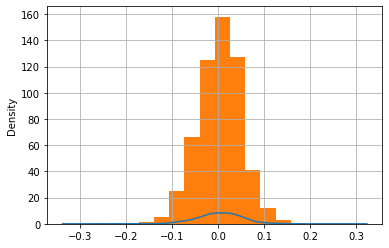

In [48]:
all_lambdas_OLS[0].iloc[:,1].plot(kind='density')
all_lambdas_OLS[0].iloc[:,1].hist()
plt.show()

## IV(Time-varying Betas)

In [49]:
holding = 21
rollingW = holding * n *12
lens = len(sim_MKT)
periods = int((lens - rollingW) / holding) - 1
print(rollingW, periods)

2520 563


In [50]:
all_betas_ev = []
all_betas_iv = []

# i is time in periods
for i in tqdm(range(periods)):

    sim_MKT_tmp = sim_MKT.iloc[i*holding:i*holding+rollingW,:]
    sim_SR_tmp = sim_SR.iloc[i*holding:i*holding+rollingW,:]
    

    if (i + 1) % 2 == 1:
        rw_odd = pd.DataFrame()
        for k in range(0,n*12,2):
            rw_odd = pd.concat([rw_odd,sim_MKT_tmp.iloc[21*k:21*(k+1),:]])

        betas_ev = []
        # j is cross-sectional stock label
        for j in sim_SR.columns:
            df_index = rw_odd.index
            b = list(ols_model.fit(sim_MKT_tmp.loc[df_index,:].values, sim_SR_tmp.loc[df_index,j].values).coef_)
            betas_ev.append(b)
        df_betas_ev = pd.DataFrame(np.array(betas_ev))
        all_betas_ev.append(df_betas_ev)
        
        rw_even = pd.DataFrame()         
        for k in range(1,n*12,2):
            rw_even = pd.concat([rw_even,sim_MKT_tmp.iloc[21*k:21*(k+1),:]])
        
        betas_iv = []
        # j is stock
        for j in sim_SR.columns:
            df_index = rw_even.index   
            b = list(ols_model.fit(sim_MKT_tmp.loc[df_index,:].values, sim_SR_tmp.loc[df_index,j].values).coef_)
            betas_iv.append(b)      
        df_betas_iv = pd.DataFrame(np.array(betas_iv))
        all_betas_iv.append(df_betas_iv)


    if (i + 1) % 2 == 0:
        rw_odd = pd.DataFrame()
        for k in range(0,n*12,2):
            rw_odd = pd.concat([rw_odd,sim_MKT_tmp.iloc[21*k:21*(k+1),:]])

        betas_iv = []
        # j is stock
        for j in sim_SR.columns:
            df_index = rw_odd.index   
            b = list(ols_model.fit(sim_MKT_tmp.loc[df_index,:].values, sim_SR_tmp.loc[df_index,j].values).coef_)
            betas_iv.append(b)        
        df_betas_iv = pd.DataFrame(np.array(betas_iv))
        all_betas_iv.append(df_betas_iv)
        
        rw_even = pd.DataFrame()   
        for k in range(1,n*12,2):
            rw_even = pd.concat([rw_even,sim_MKT_tmp.iloc[21*k:21*(k+1),:]])

        betas_ev = []
        # j is stock
        for j in sim_SR.columns:
            df_index = rw_even.index         
            b = list(ols_model.fit(sim_MKT_tmp.loc[df_index,:].values, sim_SR_tmp.loc[df_index,j].values).coef_)
            betas_ev.append(b)
        df_betas_ev = pd.DataFrame(np.array(betas_ev))
        all_betas_ev.append(df_betas_ev)

100%|██████████| 563/563 [30:19<00:00,  3.23s/it]


In [51]:
all_betas_ev[0]

,0
0,1.401389
1,0.753847
2,0.462070
3,1.406312
4,1.393817
...,...
1995,0.960464
1996,1.565116
1997,0.903152
1998,1.662453


In [52]:
all_betas_iv[0]

,0
0,1.378678
1,0.647479
2,0.563638
3,1.438949
4,1.406275
...,...
1995,0.910327
1996,1.534326
1997,0.817236
1998,1.734301


In [53]:
## Calculating the estimated lambdas

In [54]:
holding = 1 # 1 month
rollingW = holding * n *12
lens = len(m_sim_MKT)
periods = int((lens - rollingW) / holding) - 1
print(periods, rollingW)

563 120


In [55]:
from linearmodels.iv.model import IV2SLS
# from linearmodels.iv.model import IVGMM
all_lambdas_IV = []
all_resids_IV = []

m_sim_SR_tmp_T = m_sim_SR.iloc[rollingW:rollingW+periods*holding,:].T

lambdas = []
resids = []
index_times = list(m_sim_SR_tmp_T.columns)

for k in tqdm(m_sim_SR_tmp_T.columns):
    
    i = int(index_times.index(k) / holding)

    iv = IV2SLS(dependent = m_sim_SR_tmp_T.loc[:,k].values,\
                exog = np.ones(len(m_sim_SR.T), dtype=np.uint8),\
                endog = all_betas_ev[i].values.astype(np.float64),\
                instruments = all_betas_iv[i].values.astype(np.float64))
    res = iv.fit()
    l = list(res.params)
    r = list(res.resids)
    lambdas.append(l)
    resids.append(r)

all_lambdas_IV.append(pd.DataFrame(lambdas))
all_resids_IV.append(pd.DataFrame(resids))

100%|██████████| 563/563 [00:03<00:00, 147.72it/s]


In [56]:
# Use the IV estimator equation to calculate lambdas

In [57]:
all_resids_IV = pd.DataFrame(all_resids_IV[0].T)
all_resids_IV

,0,1,2,3,4,5,6,7,8,9,...,553,554,555,556,557,558,559,560,561,562
0,0.002625,-0.003630,-0.000793,0.001822,-0.001580,0.016135,0.013107,-0.004262,0.024887,0.019800,...,0.004892,-0.013819,0.007719,0.041431,-0.010135,-0.005977,0.008420,-0.011234,0.011825,0.023537
1,-0.011694,0.168415,-0.000511,-0.031640,0.122665,0.012294,-0.126169,0.082987,0.191975,-0.114324,...,-0.061083,-0.024359,0.084995,-0.016784,-0.029153,0.009934,0.073619,0.231430,-0.040663,-0.182277
2,-0.107898,0.072569,0.165625,0.013018,-0.072255,0.143647,0.076839,-0.035380,0.019541,-0.076270,...,0.044495,0.139409,-0.042624,-0.190374,0.022923,0.081212,0.066607,0.128387,0.058826,-0.046668
3,0.012621,-0.009799,0.005622,-0.052334,-0.001312,-0.024941,0.035187,0.028601,0.000835,0.007005,...,-0.058708,0.064285,-0.028235,0.022543,0.016122,-0.062457,-0.065941,0.012561,0.057844,-0.001998
4,-0.000764,0.011174,0.005342,-0.007102,0.037288,0.016951,-0.012675,-0.052906,0.054199,-0.007321,...,0.046013,-0.001444,-0.026161,0.016746,0.053052,0.001393,-0.042284,-0.023560,-0.006828,-0.024687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-0.033477,0.009586,0.046561,-0.150332,0.187217,-0.068872,-0.034444,-0.044303,-0.015205,0.000789,...,-0.025204,0.000459,-0.048458,0.195207,-0.088809,-0.118152,0.103569,0.050455,-0.061208,-0.121704
1996,-0.063738,-0.012197,0.053362,0.029127,-0.013972,-0.108875,0.029280,-0.012912,-0.059025,0.028526,...,-0.111663,0.164866,0.051173,0.022622,-0.072687,-0.040727,-0.194740,-0.016143,-0.028043,-0.035310
1997,0.005804,0.004385,-0.012496,0.057856,0.001695,-0.008623,0.004998,-0.040849,0.020485,0.008488,...,0.027099,-0.064256,0.041341,0.015781,0.026913,-0.007383,0.053797,0.031461,0.049802,0.013137
1998,0.087301,-0.032345,0.018855,0.019459,0.027258,-0.062398,0.034029,0.014681,-0.063020,-0.044326,...,0.037276,-0.026430,0.004074,0.007712,-0.049151,0.002422,-0.002637,-0.058031,-0.095830,-0.059609


In [58]:
## test whether beta_iv (instrumental variables) is exogenous
corr_iv_res = []

for i in range(np.shape(all_resids_IV)[1]):
    corr = stats.pearsonr(all_betas_iv[i].values.astype(np.float64).flatten(),all_resids_IV.iloc[:,i].values.astype(np.float64).flatten())[0]
    corr_iv_res.append(corr)

print(np.mean(corr_iv_res), "IV is Endogenous" if np.mean(corr_iv_res).round(10)!=0 else "IV is Exogenous") 

-2.5514185014286322e-17 IV is Exogenous


In [59]:
## test whether beta_ev (explanatory variables) is exogenous
corr_ev_res = []

for i in range(np.shape(all_resids_IV)[1]):
    corr = stats.pearsonr(all_betas_ev[i].values.astype(np.float64).flatten(),all_resids_IV.iloc[:,i].values.astype(np.float64).flatten())[0]
    corr_ev_res.append(corr) 
    
print(np.mean(corr_ev_res), "EV is Endogenous" if np.mean(corr_ev_res).round(10)!=0 else "EV is Exogenous") 


-0.00035671273633356505 EV is Endogenous


In [60]:
## weak instrument variable test
## the following calculate the average cross-sectional correlations between odd- and even-month betas 

In [61]:
corr_ev_iv = []

for i in range(len(all_betas_ev)):
    corr = stats.pearsonr(all_betas_ev[i].values.astype(np.float64).flatten(),all_betas_iv[i].values.astype(np.float64).flatten())[0]
    corr_ev_iv.append(corr)
    
print(np.mean(corr_ev_iv), "IV is Strong" if np.mean(corr_ev_iv)>0.5 and stats.ttest_1samp(corr_ev_iv, 0.0)[0] > 2 else "IV is Weak")

0.9894902052155073 IV is Strong


In [62]:
## and also calculate the average cross-sectional correlations between estimated and true betas 

In [63]:
corr_ev_true = []

for i in range(len(all_betas_ev)):
    corr = stats.pearsonr(all_betas_ev[i].values.astype(np.float64).flatten(),sim_betas.iloc[0,:].values.astype(np.float64).flatten())[0]
    corr_ev_true.append(corr)

print(np.mean(corr_ev_true), stats.ttest_1samp(corr_ev_true, 0.0)[0])

0.9949115130499829 80269.37711678927


In [64]:
all_lambdas_IV[0].rename(columns={0:'Intercept',1:'MKT'})

,Intercept,MKT
0,-0.002368,0.051126
1,0.001907,0.041629
2,-0.005361,-0.013381
3,-0.000568,0.050380
4,-0.000138,-0.063568
...,...,...
558,0.000058,-0.070123
559,-0.005206,0.020406
560,-0.001167,-0.016679
561,-0.002940,0.029019


In [65]:
stats.ttest_1samp(all_lambdas_IV[0], 0.0)

Ttest_1sampResult(statistic=array([0.93920846, 1.78481553]), pvalue=array([0.34802721, 0.07483051]))

In [66]:
all_lambdas_IV[0].describe()

,0,1
count,563.000000,563.000000
mean,0.000148,0.003494
std,0.003734,0.046446
min,-0.012681,-0.173350
25%,-0.002238,-0.026477
50%,0.000146,0.003968
75%,0.002585,0.033917
max,0.010932,0.158487


In [67]:
print(np.mean(mean_MKT*21), np.mean(all_lambdas_IV[0].iloc[:,1]))

0.004833333333333333 0.0034937184078479293


In [68]:
print("ex-ante bias(%): " + str((np.mean(all_lambdas_IV[0].iloc[:,1]) - mean_MKT*21)/(mean_MKT*21)*100))
print("ex-post bias(%): " + str((np.mean(all_lambdas_IV[0].iloc[:,1]) - np.mean(m_sim_MKT.values))/np.mean(m_sim_MKT.values)*100))   

ex-ante bias(%): -27.7161708721118
ex-post bias(%): -14.22683452122326
